In [653]:
import pysrt
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import json
stop_fr = pd.read_json("stop_words_french.json")
verbes = pd.read_csv("verbes.csv", encoding='utf-8')["Verbes"].to_list()
adverbes = pd.read_csv("Adverbes.csv", encoding='utf-8')["Adverbes"].to_list()

import spacy
nlp = spacy.load('fr_core_news_md')

In [654]:
from pprint import pprint 

from pythonopensubtitles.opensubtitles import OpenSubtitles
from pythonopensubtitles.utils import File

In [655]:
ost = OpenSubtitles() 
ost.login('guillaume.grelet+ost@gmail.com', 'Relish-Hatching-Ocean7-Tripod-Detention')

'yLeS,BZNj-6OsnjYleMk,hLZ9Ya'

In [817]:
movie_name = "fight club 1999"

In [821]:
query = ost.search_subtitles([{"query": movie_name, "sublanguageid": "fre"}])[3]
id_subtitle_file = query["IDSubtitleFile"]
sub_file_name = query["SubFileName"]
print(sub_file_name)

Fight.Club.1999.720p.BluRay.x264-BestHD.srt


In [822]:
ost.download_subtitles(
    ids=[id_subtitle_file],
    override_filenames={id_subtitle_file: sub_file_name},
    extension='srt',
    encoding=query["SubEncoding"]
)

{'1951974028': './Fight.Club.1999.720p.BluRay.x264-BestHD.srt'}

In [823]:
subs = pysrt.open(sub_file_name)

In [824]:
subs_text = []
for sub in subs:
    subs_text.append(sub.text)

In [825]:
subtitles = pd.DataFrame()
subtitles["text"] = subs_text
subtitles["text"] = subtitles["text"].fillna("")

In [826]:
subtitles.head(50)

,text
0,REGARDEZ TOUTE LA VOD EN HQ @4KVOD.TV\nLA TV L...
1,<i>On me demande sans arrêt\nsi je connais Tyl...
2,Trois minutes.
3,Nous y voilà.
4,Déflagration maximum.
5,Quelques mots pour marquer le coup ?
6,"<i>Avec un canon dans la bouche,\nseules les v..."
7,Rien ne me vient à l'esprit.
8,<i>J'en oublie le projet\nde chaos organisé de...
9,<i>et me demande\nsi le canon est propre.</i>


In [827]:
subtitles["text"]  = subtitles["text"].apply(lambda x:re.sub(r'[^\w\s]', ' ', x))

In [828]:
words_list = [rev for rev in subtitles["text"].apply(lambda x:x.split(' '))]
words_i = [list(range(len(rev))) for rev in subtitles["text"].apply(lambda x:x.split(' '))]


In [829]:
flat_words_list = [item for sublist in words_list for item in sublist]
flat_words_i = [item for sublist in words_i for item in sublist]


In [830]:
df_words = pd.DataFrame()
df_words["words"] = flat_words_list
df_words["indice"] = flat_words_i


In [831]:
df_words = df_words[df_words["words"].apply(len)>0]

In [832]:
df_words["nom_propre"] = 1*(df_words["words"].apply(lambda x:x[0].isupper()))*(df_words["indice"]!=0)

In [833]:
df_words["words"] = df_words["words"].apply(lambda x:x.lower())

In [834]:
nom_propres = df_words[df_words["nom_propre"]==1][["words","nom_propre"]]

In [835]:
df_words = df_words.drop("nom_propre",axis=1)

In [836]:

df_words = df_words.merge(nom_propres.drop_duplicates("words"),on="words",how='left')

df_words["nom_propre"] = df_words["nom_propre"].fillna(0)

In [837]:
df_words_lemma = df_words[df_words["nom_propre"]==0].drop_duplicates("words")

In [838]:
df_words_lemma["lemma"] = df_words_lemma["words"].apply(lambda x:nlp(x)[0].lemma_)

In [839]:
df_words = df_words.merge(df_words_lemma[["words","lemma"]],
               on = "words",
               how = "left")

In [840]:
df_words["lemma"] = df_words["lemma"].fillna(df_words["words"])

In [841]:
df_words["lemma"] = df_words["lemma"].apply(lambda x:x.replace(" ",""))

In [842]:
stop_words = stop_fr[0].to_list() + list(STOPWORDS) + verbes + adverbes + movie_name.split(" ") + ["oui","allez","ll","lls"]

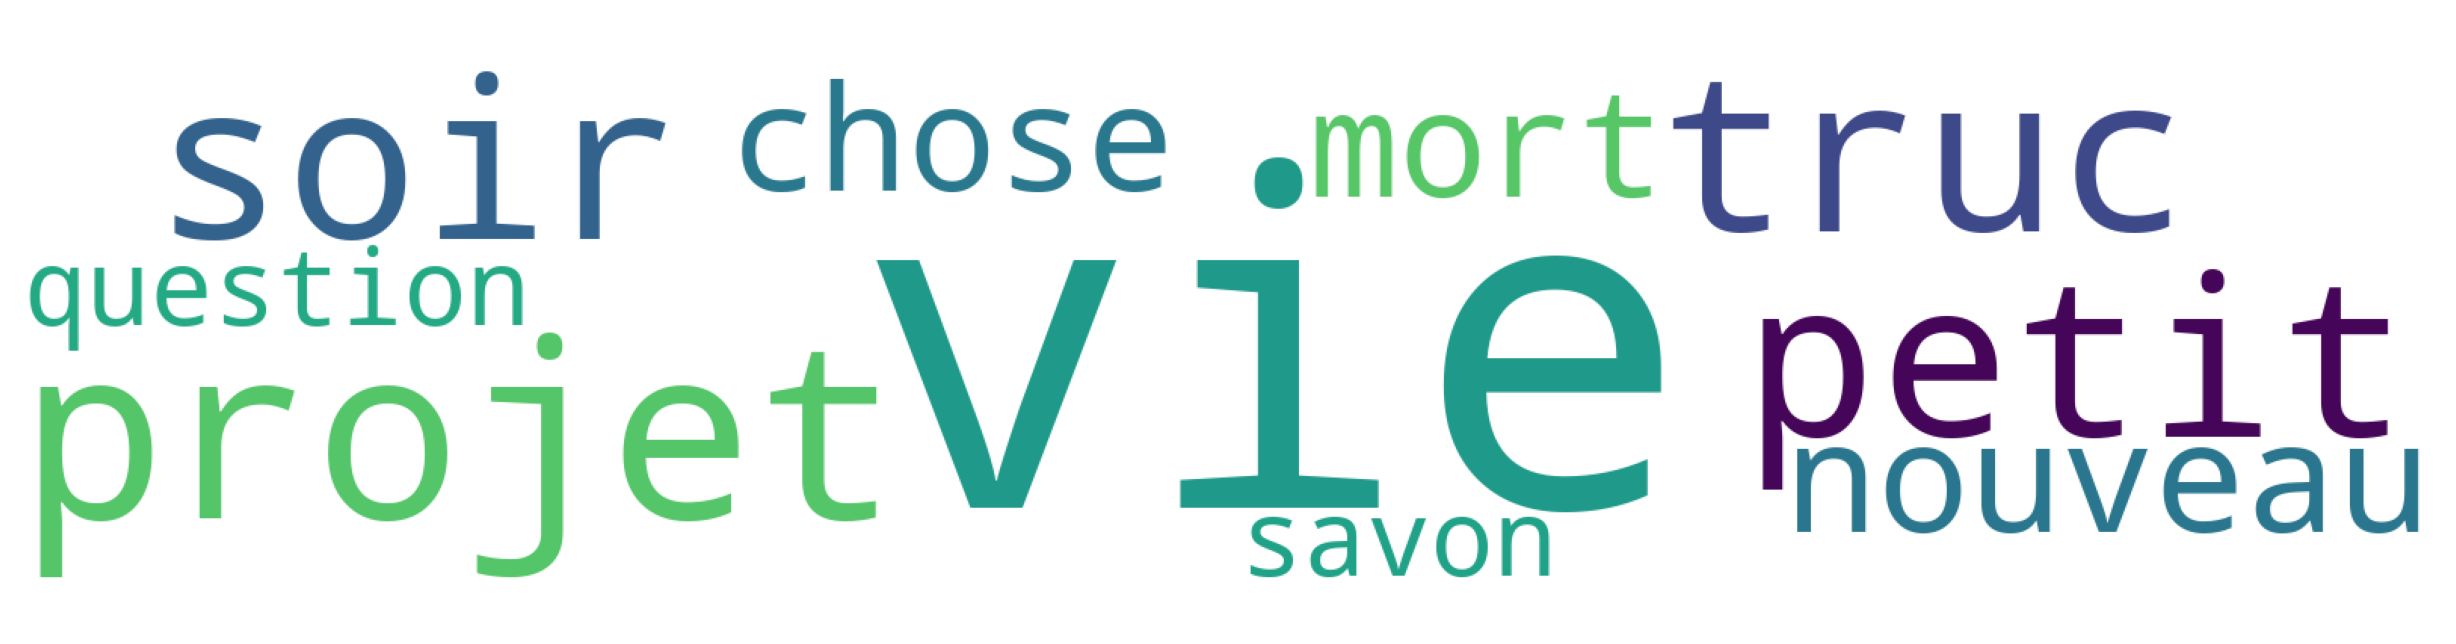

In [843]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            max_words = 10,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

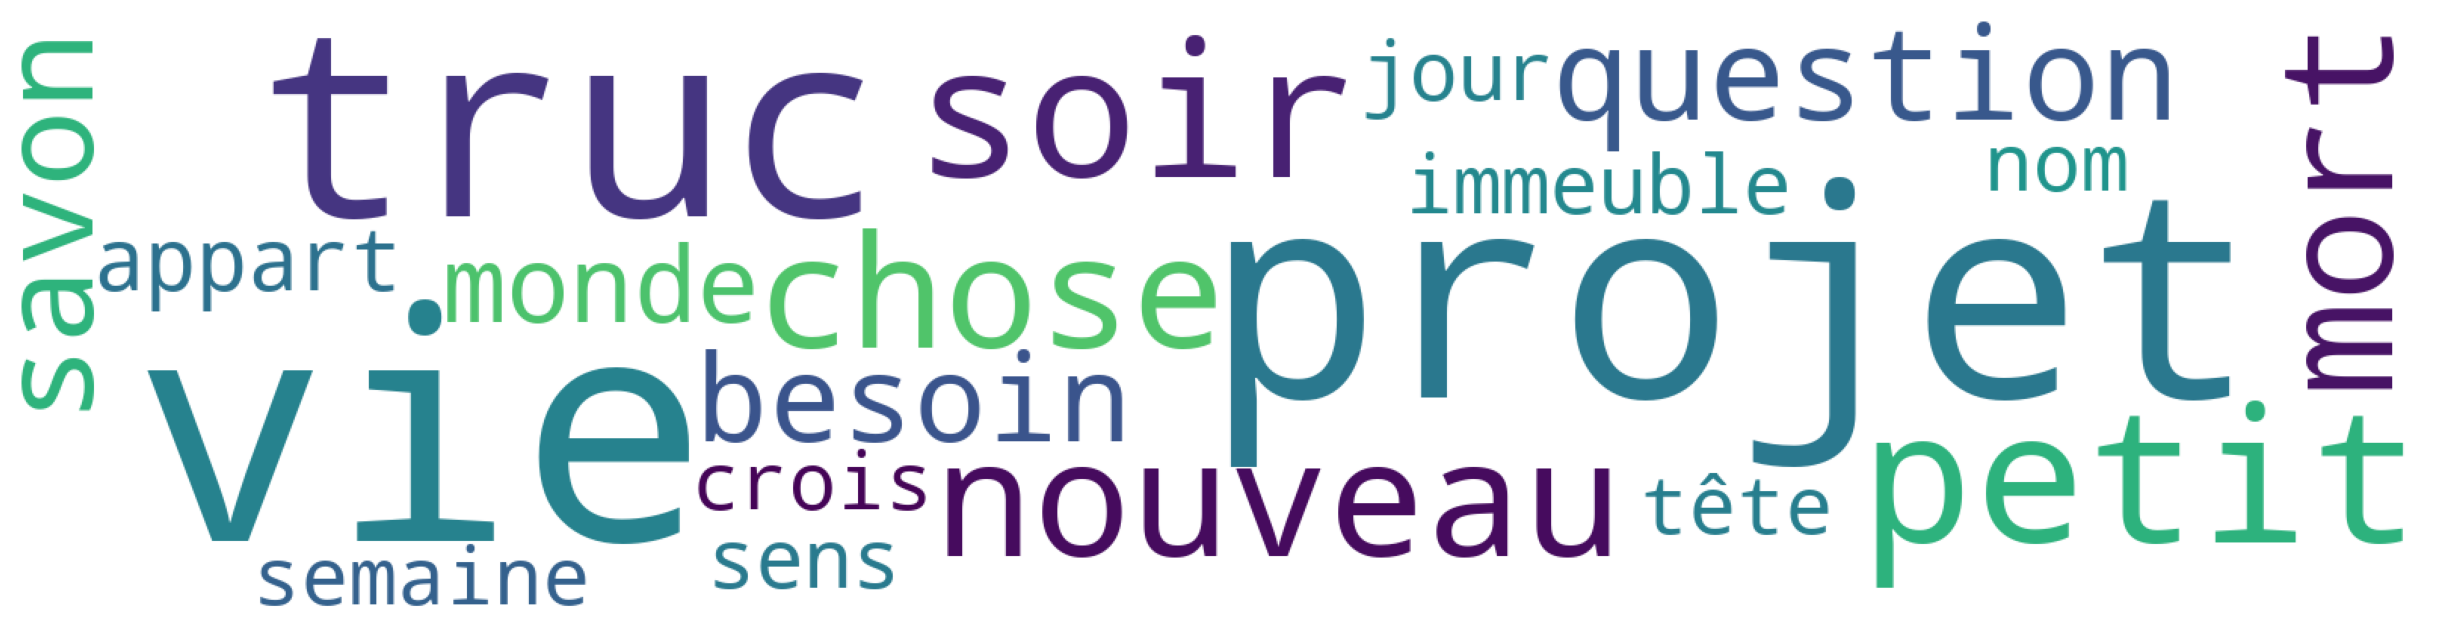

In [844]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            max_words = 20,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

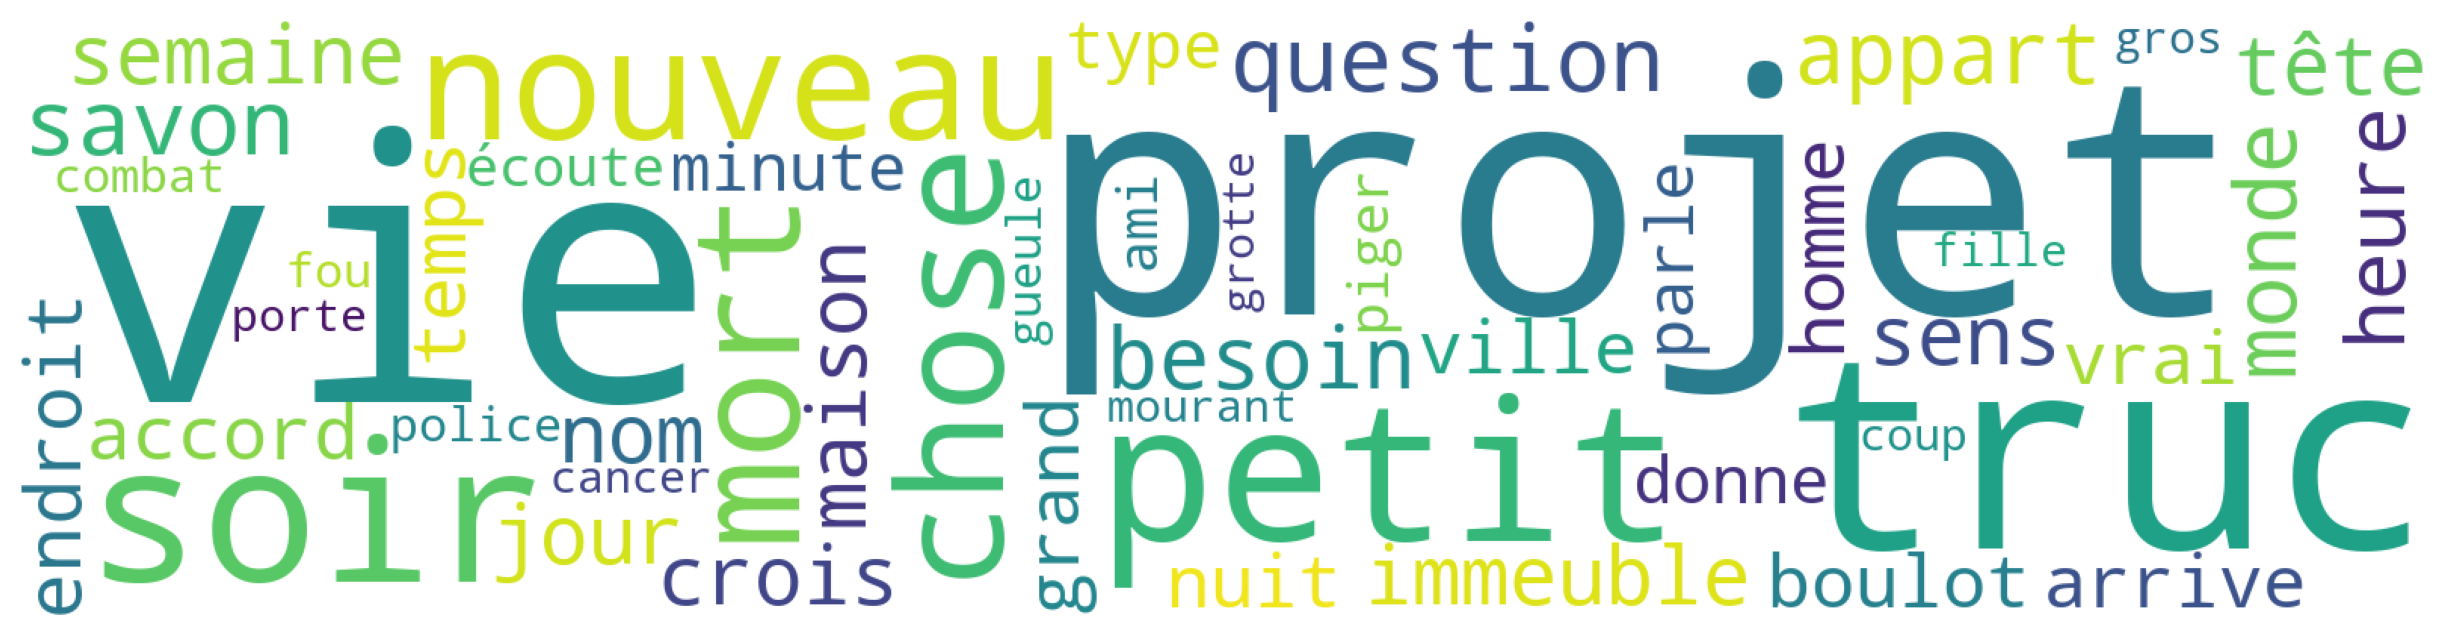

In [845]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            max_words = 50,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

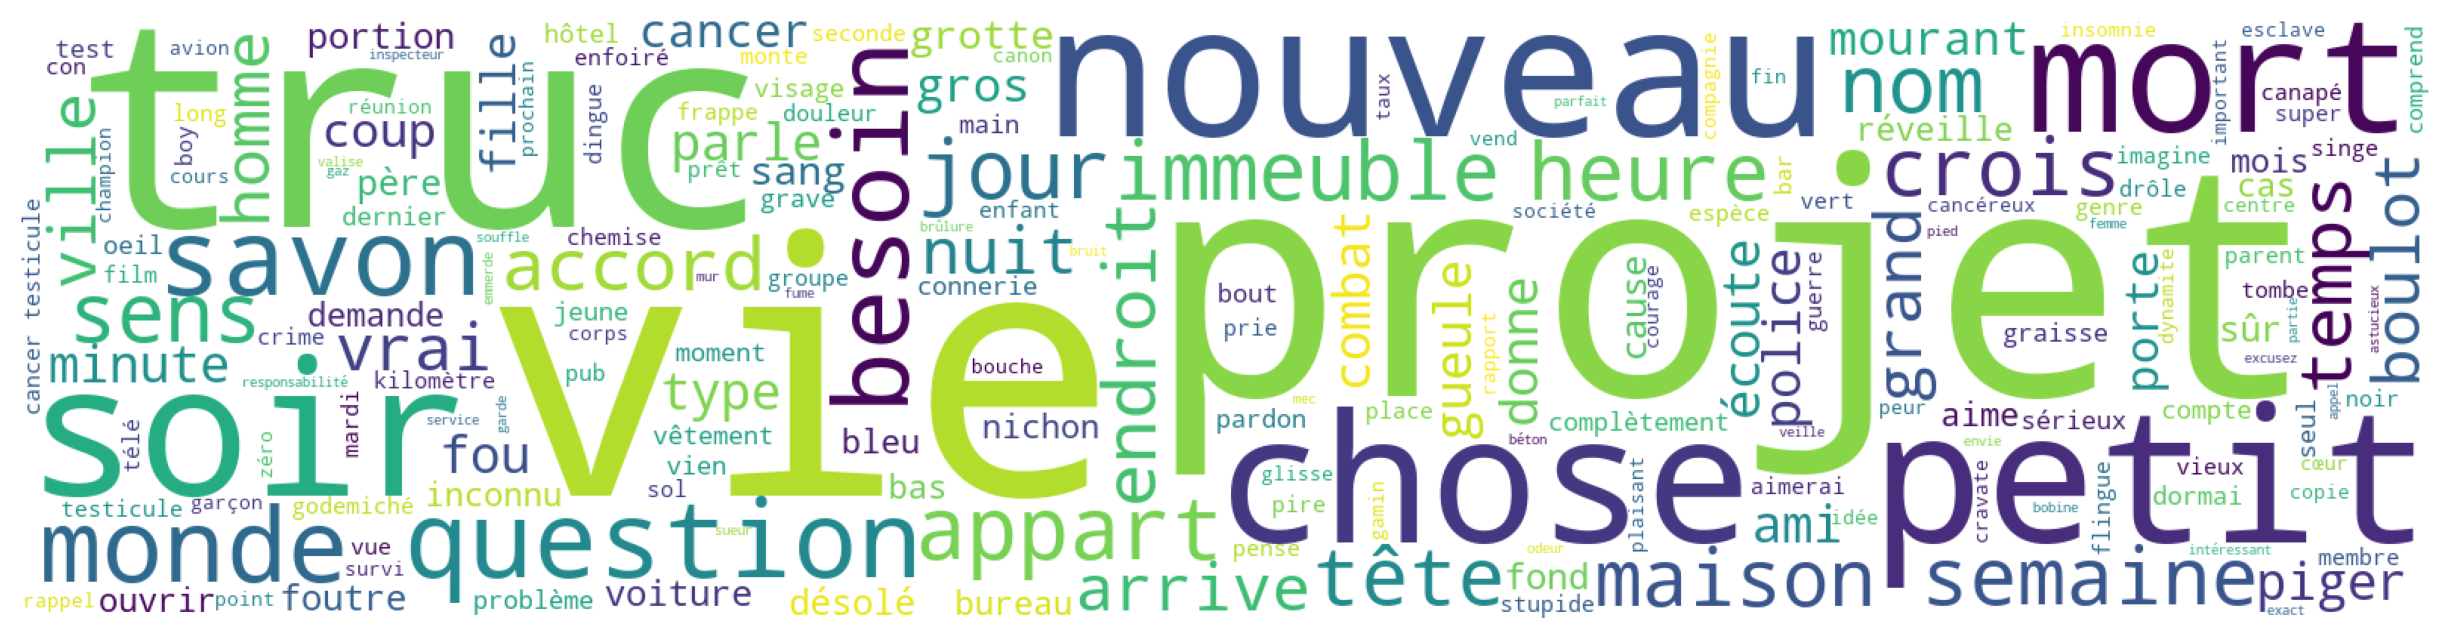

In [846]:
df_words_wc = df_words[df_words["nom_propre"]==0]
#df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()

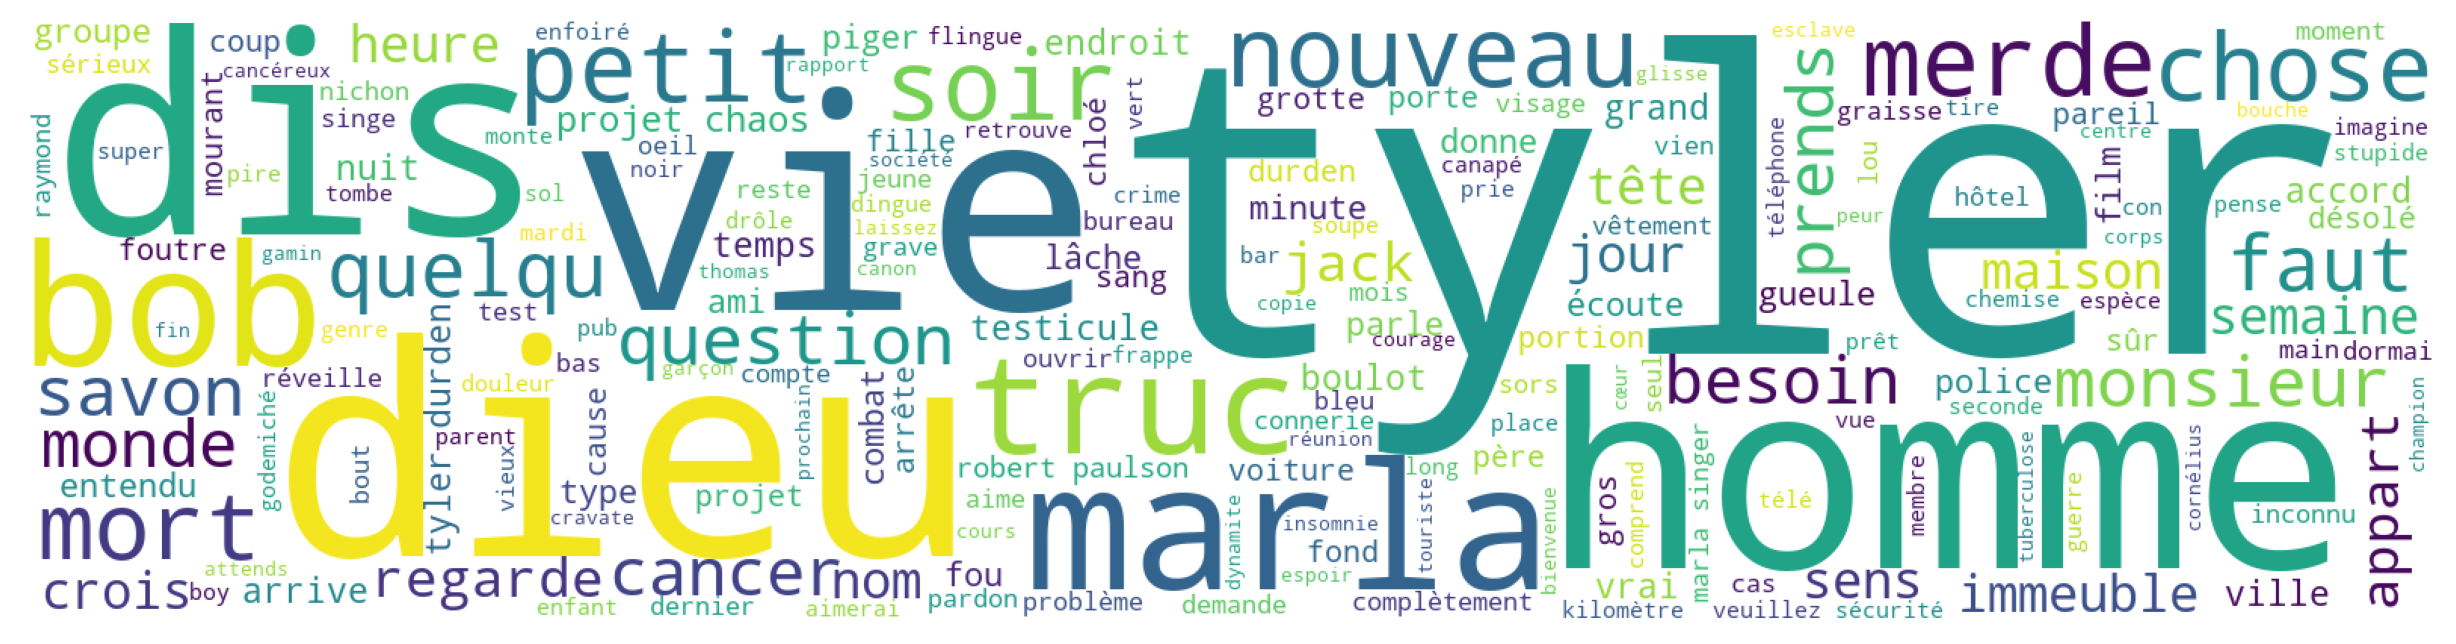

In [847]:
df_words_wc = df_words
docs = df_words_wc["lemma"]
text_wc = " ".join(rev for rev in docs)
plt.figure(figsize=(16, 4),
                       dpi=200)
plt.axis("off")
plt.imshow(
            WordCloud(width=1600,
            height=400,
            background_color="white",stopwords = stop_words).generate(text_wc))
plt.show()